# 은행거래 사기

## 목차
1. [배경](#배경)
1. [준비](#준비)
1. [데이터](#데이터)
1. [탐험](#탐험)
1. [변형](#변형)
1. [학습](#학습)
1. [호스팅](#호스팅)
1. [평가](#평가)
1. [확장](#확장)


## 배경
은행거래에서의 사기를 판별하는 것은 실제 은행에서 매우 중요한 일이며 동시에 기계학습 파이프라인을 학습하기에 매우 좋은 주제입니다.
이 과제를 통하여 kaggle 에 호스팅된 가상의 금융 거래 데이터에 대해 데이터 분석 및 이진 분류 모델을 (binary classifier) 만들어 보겠습니다.

우리는 가상의 은행거래 데이터를 사용할 것입니다. 여기서 3개의 categorical feature 와 6개의 numeric feature 를 사용하여 해당 거래 내역의 사기 여부를 판단하는 target variable (isFraud) 을 예측하는 모델을 만들것입니다.

## 준비

In [1]:
!pip install -U sagemaker

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'sagemaker/DEMO-xgboost-dm'           # prefix used for all data stored within the bucket

# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.serializers import CSVSerializer
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page

## 데이터
Kaggle 계정을 생성하고 아래 링크를 통해서 데이터를 다운로드하십시오.

https://www.kaggle.com/ntnu-testimon/paysim1 

In [4]:
df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')

In [5]:
df.shape
# 6.3백만개의 row 와 11개의 column 이 존재합니다

(6362620, 11)

In [6]:
df.head()
# 각 column 을 살펴봅니다

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### https://www.kaggle.com/ntnu-testimon/paysim1

데이터 셋에 대하여 다음과 같은 설명을 확인 할 수 있습니다.

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

우리는 이 실험에서 isFraud 를 예측하는 모델을 만들 것입니다. isFraud 가 1 (True) 인 값이 얼마나 많은지 확인해보겠습니다.

In [7]:
df['isFraud'].mean() # 0.001290820448180152 = 전체의 0.13%

0.001290820448180152

In [8]:
df['isFlaggedFraud'].mean()

2.51468734577894e-06

## 탐험
모델을 만들기 위하여 어떤 feature 가 있는지, feature engineering 이 필요한지 파악해야 합니다. 이를 위하여 EDA (Exploratory Data Analysis) 를 진행합니다

두가지 종류의 feature 를 확인합니다.
- categorical feature: 카테고리 종류 확인
- numeric feature: 데이터의 분포 확인

In [9]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    print(column, len(df[column].unique()))

type 5
nameOrig 6353307
nameDest 2722362


카테고리 데이터는 총 3개 존재합니다

- type 은 5개의 카테고리가 있으므로 one-hot-encoding 으로 변형하여 사용하겠습니다.
- nameOrig, nameDest 는 너무나 많은 카테고리가 존재하므로 사용하지 않습니다.

In [10]:
column = 'type'
display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))
# 아래의 5가지 카테고리를 확인 할 수 있습니다

col_0,% observations
type,
CASH_IN,0.219923
CASH_OUT,0.351663
DEBIT,0.006512
PAYMENT,0.338146
TRANSFER,0.083756


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


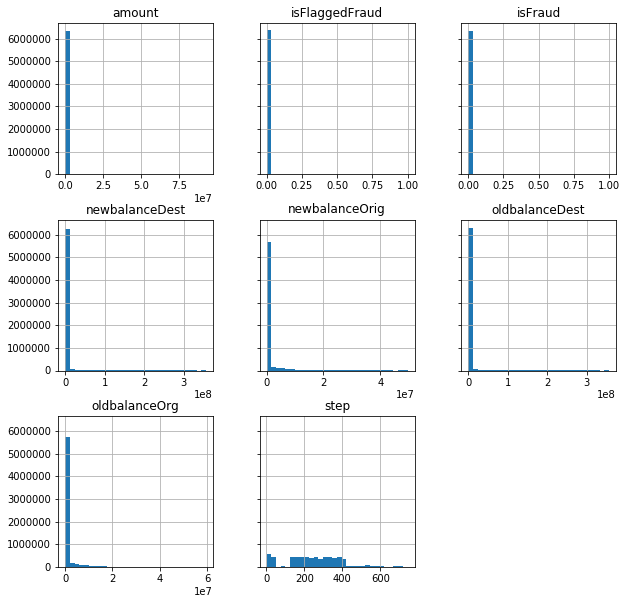

In [11]:
# 히스토그램을 통해 numeric features 의 분포 확인
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

Correlation 확인

numeric feature 의 분포를 살펴보았습니다. 각 feature 가 얼마나 유용할지 간접적으로 살펴보기 위하여 target variable 인 isFraud 와의 상관관계를 살펴보겠습니다.

In [12]:
y_column = 'isFraud'
x_column = 'type'
display(pd.crosstab(index=df[x_column], columns=df[y_column], normalize='columns'))

isFraud,0,1
type,,
CASH_IN,0.220207,0.000000
CASH_OUT,0.351470,0.501157
DEBIT,0.006520,0.000000
PAYMENT,0.338583,0.000000
TRANSFER,0.083220,0.498843


step


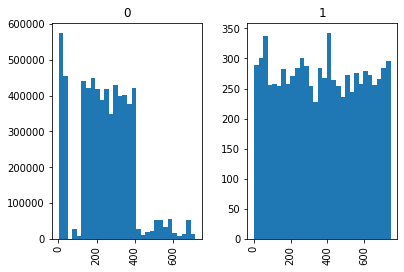

amount


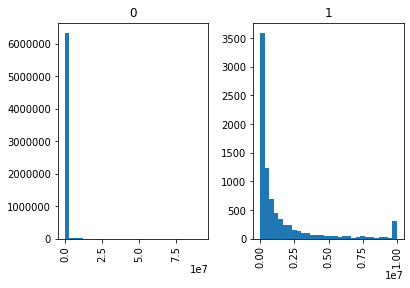

oldbalanceOrg


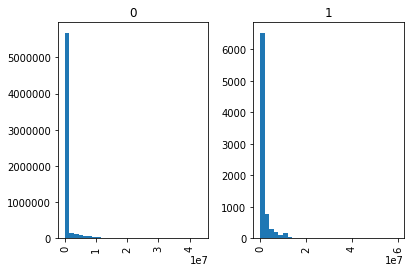

newbalanceOrig


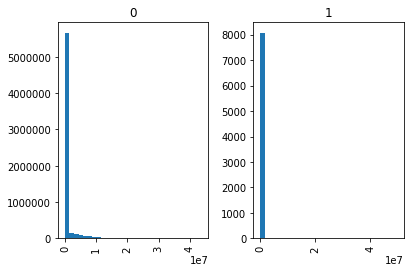

oldbalanceDest


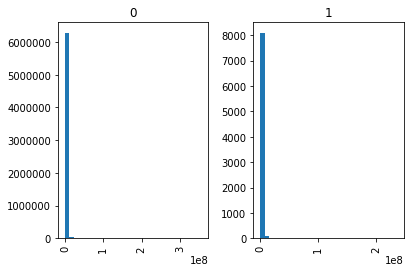

newbalanceDest


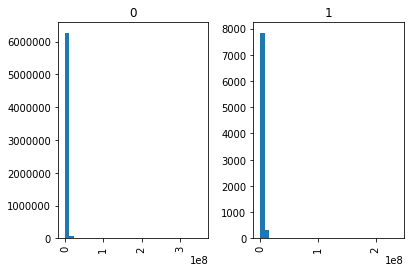

isFraud


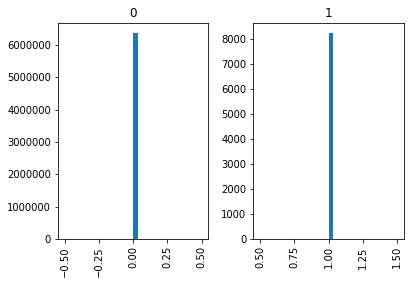

isFlaggedFraud


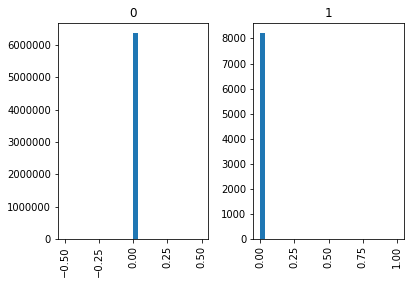

In [13]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[column].hist(by=df[y_column], bins=30)
    plt.show()

In [14]:
display(df.corr())

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


## Feature Engineering


- categorical feature: type 카테고리의 각 값들 (cash_in, cash_out, ...) 을 새로운 column 으로 사용합니다. 이를 one-hot encoding 이라 부릅니다
- numeric feature: 원래의 값 (raw value) 들을 특정 영역대의 값으로 변환하기 위하여 min-max scaler 를 적용합니다.

우선 type 이라는 categorical feature 를 one-hot-encoding 으로 변환합니다. 이를 통해 각 category 에 해당하는 5개의 column 을 새로 만듭니다. 이를 사용하고, 원래의 type column 은 사용하지 않을 것입니다.

In [15]:
one_hot = pd.get_dummies(df['type'])
one_hot.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


6개의 numeric feature 에 대하여 min-max-scaler 를 적용합니다. 이에 대한 더 자세한 정보는 여기서 살펴볼 수 있습니다.
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

기존의 6개의 column 과 새로 생성한 6개의 column 을 모두 사용할것입니다

In [16]:
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(df[numeric_features])

In [17]:
transformed_data

array([[0.00000000e+00, 1.06437179e-04, 2.85534757e-03, 3.23275647e-03,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.01662565e-05, 3.56616357e-04, 3.90938877e-04,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.95790998e-06, 3.03767521e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 6.82716643e-02, 1.05922716e-01, 0.00000000e+00,
        1.92375796e-04, 1.79120417e-02],
       [1.00000000e+00, 9.19463216e-03, 1.42653679e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.19463216e-03, 1.42653679e-02, 0.00000000e+00,
        1.82859791e-02, 2.06640365e-02]])

In [18]:
transformed_df = pd.DataFrame(transformed_data)
transformed_df

,0,1,2,3,4,5
0,0.0,0.000106,0.002855,0.003233,0.000000,0.000000
1,0.0,0.000020,0.000357,0.000391,0.000000,0.000000
2,0.0,0.000002,0.000003,0.000000,0.000000,0.000000
3,0.0,0.000002,0.000003,0.000000,0.000059,0.000000
4,0.0,0.000126,0.000697,0.000603,0.000000,0.000000
...,...,...,...,...,...,...
6362615,1.0,0.003674,0.005701,0.000000,0.000000,0.000954
6362616,1.0,0.068272,0.105923,0.000000,0.000000,0.000000
6362617,1.0,0.068272,0.105923,0.000000,0.000192,0.017912
6362618,1.0,0.009195,0.014265,0.000000,0.000000,0.000000


In [19]:
final_df = pd.concat([df, one_hot, transformed_df], axis = 1)

In [38]:
# 최종적인 데이터 셋의 크기 입니다
final_df.shape

(6362620, 22)

In [21]:
final_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,0,1,2,3,4,5
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0,0.0,0.000106,0.002855,0.003233,0.000000,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0,0.0,0.000020,0.000357,0.000391,0.000000,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1,0.0,0.000002,0.000003,0.000000,0.000000,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0,0.0,0.000002,0.000003,0.000000,0.000059,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0,0.0,0.000126,0.000697,0.000603,0.000000,0.0


In [22]:
# 다음의 column 들은 훈련용 데이터 셋에 필요가 없기 때문에 생략 합니다.
columns_to_drop = ['type', 'isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest']


In [23]:
# train, validation, test 데이터 셋을 7:2:1 의 비율로 생성합니다.
train_data, validation_data, test_data = np.split(final_df.sample(frac=1, random_state=1729), [int(0.7 * len(final_df)), int(0.9 * len(final_df))])

In [24]:
# 각 데이터셋 (train, validation, test) 를 노트북 로컬 환경에 저장합니다.
pd.concat([train_data['isFraud'], train_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('train.csv', index=False, header=False)


In [25]:
pd.concat([validation_data['isFraud'], validation_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)


In [26]:
pd.concat([test_data['isFraud'], test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test.csv', index=False, header=False)


In [27]:
pd.concat([test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test_features.csv', index=False, header=False)


In [28]:
# 각 데이터셋 (train, validation, test) 를 s3 에 업로드 합니다.
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_features.csv')).upload_file('test.csv')


## 학습
이 노트북에서는 간단하지만 이진 분류에 효과적인 XGBoost 를 사용합니다. XGBoost 는 Gradient Boosting 을 수행하는 open source library 이비다. 우선 SageMaker 의 XGBoost ECR 컨테이너를 지정합니다

In [29]:
# from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(boto3.Session().region_name, 'xgboost')

# sagemaker 2.x sdk 에서는 아래를 사용하세요.
from sagemaker import image_uris
container = sagemaker.image_uris.retrieve(framework = 'xgboost', region = boto3.Session().region_name, version = 'latest')

우리는 CSV 파일 포맷을 사용하므로 S3의 파일 위치를 알려주는 s3_input오브젝트를 생성하고 콘텐츠 타입을 CSV로 지정합니다.



In [30]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

다음으로 다음 파라미터를 지정하여 esitmator를 생성합니다.

- xgboost 알고리즘 컨테이너를 사용
- 사용할 IAM 역할(role)
- 학습용 인스턴스 타입과 수량
- 출력데이터를 위한 S3위치
- 알고리즘 하이퍼파라미터

이제 다음 파라미터를 이용하여 .fit() 명령을 실행합니다.
- 학습용(train)/검증용(validation) 데이터가 있는 S3 위치. 본 예제는 학습과 검증 데이터셋을 모두 사용하므로 두 채널을 모두 지정합니다.

In [32]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-02-25 05:28:43 Starting - Starting the training job...
2021-02-25 05:29:08 Starting - Launching requested ML instancesProfilerReport-1614230923: InProgress
......
2021-02-25 05:30:12 Starting - Preparing the instances for training......
2021-02-25 05:31:10 Downloading - Downloading input data...
2021-02-25 05:31:34 Training - Downloading the training image...
2021-02-25 05:32:10 Training - Training image download completed. Training in progress.Arguments: train
[2021-02-25:05:31:55:INFO] Running standalone xgboost training.
[2021-02-25:05:31:55:INFO] File size need to be processed in the node: 827.47mb. Available memory size in the node: 8406.41mb
[2021-02-25:05:31:55:INFO] Determined delimiter of CSV input is ','
[05:31:55] S3DistributionType set as FullyReplicated
[05:31:59] 4453834x17 matrix with 75715178 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-25:05:31:59:INFO] Determined delimiter of CSV input is ','
[05:31:59] S3Distributio

## 호스팅

In [33]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

-------------!

## 평가

In [34]:
xgb_predictor.serializer = CSVSerializer()


In [35]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for i, array in enumerate(split_array):
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
        if i % 100 == 0:
            print(i, 'out of', len(split_array), 'completed')
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(columns_to_drop, axis=1).to_numpy())


0 out of 1273 completed
100 out of 1273 completed
200 out of 1273 completed
300 out of 1273 completed
400 out of 1273 completed
500 out of 1273 completed
600 out of 1273 completed
700 out of 1273 completed
800 out of 1273 completed
900 out of 1273 completed
1000 out of 1273 completed
1100 out of 1273 completed
1200 out of 1273 completed


In [36]:
pd.crosstab(index=test_data['isFraud'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


predictions,0.0,1.0
actuals,,
0,635406,29
1,157,670


TP, TN, FP, FN 은 다음과 같이 정의 되어 있습니다.

- TP = Truly (identified as) Positive
- TN = Truly (identified as) Negative
- FP = Falsely (identified as) Positive
- FN = Falsely (identified as) Negative

위의 테이블의 각 셀에 해당하는 것을 표시하였습니다.

| actuals\predictions | 0 | 1 |
| --- | --- | --- |
| 0 | TN | FP |
| 1 | FN | TP |


이를 바탕으로 Accuracy, Precision, Recall 을 측정할 수 있습니다.
- Accuracy = (TP + TN) / (TP + FP + FN + TP) = 0.9997
- Precision = TP / (TP + FP) = 670 / (670 + 29) = 0.9585
- Recall = TP / (TP + FN) = 670 / (670 + 157) = 0.8102

알고리즘의 샘플링과정에서 랜덤요소가 반영되므로 결과의 숫자는 위 결과와 정확히 동일하지 않을 수 있습니다.

## (옵션) 리소스 제거
본 예제를 모두 마무리한 후 아래 셀을 실행합니다. 다음 명령은 추론 단계에서 생성한 SageMaker에서 호스팅되고 있는 엔드포인트를 제거합니다. 엔드포인트를 삭제하지 않으면 계속 사용요금이 발생할 수 있습니다.



In [37]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
